## Red Neuronal Recurrente Bidireccional

In [3]:
#!pip install torch

In [1]:
import torch

# Creamos un modelo RNN de ejemplo
model = torch.nn.RNN(input_size=500,hidden_size=500)

In [2]:
import torch.nn as nn

class RNNode(nn.Module):
    ''' Clase que representa un nodo de una RNN
    params:
    - input_size(int): tamaño del embeding de la caracteristica de entrada
    - hiden_size(int): tamaño del vector del estado oculto el cual va retener información de la secuencia
    '''
    def __init__(self,input_size:int,hidden_size:int) -> None :
        # Inicializa la clase base nn.Module
        super(RNNode,self).__init__()

        # Atributos (int) de la clase
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Atributos (nn.Linear [ capa lineal ]) de la clase
        #-------------------------------------------------------------#
        # Capa Lineal [entradas: input_size] -> [salidas : hidden_size]
        self.ih = nn.Linear(input_size,hidden_size)

        # Capa Lineal [entradas: hidden_size] -> [salidas : hidden_size]
        self.hh = nn.Linear(hidden_size,hidden_size)
    
    def forward(self,x,h_anterior=None):
        # Evaluamos en el caso que no exista un h
        if h_anterior is None:
            # Inicializa h como un tensor de zeros (1, hidden_size)
            #print(f'x: {x}')
            h_anterior = torch.zeros( 1 , self.hidden_size )
            
            #print(f'H_0 (size): {h_anterior.size()}')
            #print(f'H_0 : \n {h_anterior}')
        
        h = torch.tanh( self.ih(x) + self.hh(h_anterior) )
        
        return h
 

In [3]:
cell = RNNode(100,300)

# Crear un tensor de entrada
x_input = torch.randn(1, 100)

# Llamar al objeto de la clase como si fuera una función
output = cell(x_input)

print(output.shape)

torch.Size([1, 300])


## Clase RNN personalizada

In [4]:
class RNN_ANN(nn.Module):
    def __init__(self, input_size, hidden_size , output_size=1):
        super(RNN_ANN,self).__init__()

        # Atributos (tipo NNode)
        self.cell = RNNode(input_size=input_size,hidden_size=hidden_size)
        # Atributo ANN simple, Capa que determina el sentimiento
        self.f_sent = nn.Linear(hidden_size,output_size)
    
    def forward(self, secuencia ,h = None):
        ''' Metodo que genera un tensor h_t usando la clase Node y se le pasa un h_anterior

        params:
        - secuencia list[ x_input ] : representa una matriz de n_inputs con tamaño x_input
        - h_inicial: representa el tensor oculto inicial de la capa oculta
        '''

        for x_input in secuencia:
            h = self.cell(x_input, h)
        
        #print(f'Output shape before tanh: {h.shape}')
        output = self.f_sent(h)
        #print(f'Output shape before tanh: {output.shape}')
        output = torch.tanh(output)
        #print(f'Output shape after tanh: {output.shape}')
        output = output.squeeze()
        #print(f'Output shape after squeeze: {output.shape}')
        return output

In [5]:
# Creamos una clase para analizar sentimientos
import matplotlib.pyplot as plt

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, Preprocessor):
        super(SentimentRNN,self).__init__()
        # Atributos - preprocesador
        self.Preprocessor = Preprocessor

        # Atributos - modelo (tipo RNN_ANN)
        self.model= RNN_ANN(input_size,hidden_size,output_size)
        # Definimos la funcion de perdida
        self.loss = nn.MSELoss()
        # Definimos el optimizador (le pasamos los parametros del modelo)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self,X_train, y_train,epoch=10):
        ''' Metodo que entrena el modelo con un conjunto de datos de entrenamiento
        preprocesador como un conjunto de secuencias y sus targets
        '''
        # ALmacenamos la perdida total de cada epoca en una lista
        loss_list = []
        for e in range(epoch):
            # Almacenamos la perdida total
            total_loss = 0
            for secuencia,target in zip(X_train,y_train):
                #print(f'Secuencia: {secuencia}')
                #print(f'tamaño de la secuencia: {len(secuencia)}')
                # Inicializamos el gradiente
                self.optimizer.zero_grad()

                # Pasamos la secuencia a la red
                output = self.model(secuencia)

                # Imprimimos el output y el target
                #print(f'Output: {output}, Target: {target}')
                
                # Calculamos la perdida
                loss = self.loss(output,target)

                
                # Calculamos el gradiente
                loss.backward()

                # Actualizamos los pesos
                self.optimizer.step()

                # Acumulamos la perdida
                total_loss += loss.item()

            # Almacenamos la perdida total de la epoca
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        
        # Almacenamos los errores en un atributo
        self.loss_list = loss_list
    
    def plot_loss(self):
        ''' Metodo que grafica la perdida del modelo
        '''
        
        plt.plot(self.loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    
    def evaluate(self,X_test,y_test):
        ''' Metodo que evalua el modelo con un conjunto de datos de test
        preprocesador como un conjunto de secuencias y sus targets
        '''
        correct = 0
        total = 0

        # Desactivamos el calculo de gradientes
        with torch.no_grad():
            # Almacenamos la perdida total
            total_loss = 0
            for secuencia,target in zip(X_test,y_test):
                output = self.model(secuencia)
                # Calculamos el loss
                loss = self.loss(output,target)
                # Acumulamos la perdida
                total_loss += loss.item()
            
            # Calculamos el error cuadratico medio
            mse = total_loss/len(X_test)
            print(f'MSE: {mse}')
        
        return mse
    
    def predict(self,texto):
        ''' Metodo que predice el sentimiento de un texto
        '''
        # Preprocesamos el texto
        secuencia = self.Preprocessor.get_embedding_texto(texto)
        # Pasamos la secuencia por la red
        output = self.model(secuencia)
        # Retornamos el valor de salida
        return output.item()

# Guardamos modelo de embeddings

In [ ]:
import gensim.downloader as api
import pickle

# Cargar el modelo de embeddings una vez y guardarlo en un archivo
def save_embedding_model(model_name, file_name):
    print(f"Cargando el modelo {model_name}...")
    model = api.load(model_name)
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Modelo {model_name} guardado en {file_name}")

# Guardar el modelo de GloVe
save_embedding_model("glove-wiki-gigaword-100", "glove_model.pkl")
# Guardar el modelo de Word2Vec (opcional)
save_embedding_model("word2vec-google-news-300", "word2vec_model.pkl")

# Clase de preprocesamiento de Conjunto de entrenamiento

In [8]:
import re
import pandas as pd
import numpy as np
import pickle

# Creamos una clase para preprocesar los datos
class Preprocessor:    
    def __init__(self, path: str, embedding_type='glove') -> None:
        # Atributo (str) path de la clase
        self.path = path
        # Leemos el archivo
        self.text = self.read_path(self.path)
        # Creamos un diccionario de parrafos y sentimientos
        self.data = self.create_data(self.text)
        #print(self.data)
        # Creamos un dataframe
        self.df = self.create_df(self.data)
        # Creamos un df de palabras y sentimientos
        self.df_words = self.create_df_words(self.df)
        
        # Cargar modelo de embeddings
        self.embedding_type = embedding_type
        if embedding_type == 'glove':
            print("Cargando GloVe...")
            # extraemos el archivo pickle
            self.embedding_model = pickle.load(open("glove_model.pkl", 'rb'))
            self.embedding_dim = 100
        elif embedding_type == 'word2vec':
            print("Cargando Word2Vec...")
            self.embedding_model = pickle.load(open("word2vec_model.pkl", 'rb'))
            self.embedding_dim = 300
        else:
            raise ValueError("Tipo de embedding no soportado. Usa 'glove' o 'word2vec'.")

        # Creamos una lista de tensores de secuencias y sus targets
        self.X, self.y = self.create_X_y_words(self.df_words)
    
    def get_embedding_texto(self, texto: str) -> list:
        ''' Método que obtiene los embeddings de un texto '''
        texto = re.findall(r'\w+', texto.lower())
        embeddings = [self.embedding_model[word] for word in texto if word in self.embedding_model]
        # Convertimos la lista de embeddings a un tensor
        if embeddings:
                # convertimos la lista de embeddings a un tensor
            embeddings = [torch.tensor(embedding) for embedding in embeddings]
        else:
            embeddings = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas

        return embeddings
    
    def create_X_y_words(self, df: pd.DataFrame) -> list:
        ''' Método que crea una lista de embeddings de secuencias '''
        X = []
        y = []
        for parrafo,sentimiento in zip(df['parrafos'],df['sentimientos']):
            embeddings = [self.embedding_model[word] for word in parrafo if word in self.embedding_model]
            if embeddings:
                # convertimos la lista de embeddings a un tensor
                paragraph_embedding = [torch.tensor(embedding) for embedding in embeddings]
            else:
                paragraph_embedding = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas
            X.append(paragraph_embedding)
            # Convertimos el sentimiento a tensor
            sentimiento = torch.tensor(sentimiento)
            y.append(sentimiento)
        
        return X, y
    
    def create_df_words(self, df: pd.DataFrame) -> pd.DataFrame:
        ''' Método que crea un dataframe de palabras y sentimientos '''
        df_words = df.copy()
        df_words['parrafos'] = df['parrafos'].apply(lambda x: re.findall(r'\w+', x.lower()))
        return df_words
    
    def create_df(self, data: dict) -> pd.DataFrame:
        ''' Método que crea un dataframe a partir de un diccionario de parrafos y sentimientos '''
        df = pd.DataFrame(data)
        return df
    
    def create_data(self, text: str) -> dict:
        ''' Método que crea un diccionario de parrafos y sentimientos '''
        parrafos = re.findall(r'Parrafo_\d+:\n(.*?)\nsentimiento_\d+:\n', text, re.DOTALL)
        sentimientos = re.findall(r'sentimiento_\d+:\n(.*?)(?:\n|$)', text, re.DOTALL)
        # Convertimos los sentimientos a float
        sentimientos = [float(sentimiento) for sentimiento in sentimientos]
        data = {'parrafos': parrafos, 'sentimientos': sentimientos }
        return data
    
    def read_path(self, path: str) -> str:
        ''' Método que lee un archivo de texto y retorna el texto '''
        with open(path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text

In [9]:
# Uso de la clase
preprocessor_train = Preprocessor('./train_data.txt', embedding_type='glove')

Cargando GloVe...


In [10]:
len(preprocessor_train.X)

99

In [11]:
len(preprocessor_train.X[0])

16

# Creamos nuestro modelo de Analisis de sentimiento

In [12]:
# Definimos los parametros
input_size = 100
hidden_size = 300
output_size = 1

# Creamos el modelo
model = SentimentRNN(input_size, hidden_size, output_size, preprocessor_train)

# Almacenamos los datos de entrenamiento y prueba
X_train = preprocessor_train.X
y_train = preprocessor_train.y

In [13]:
y_train

[tensor(0.9000),
 tensor(0.2000),
 tensor(-0.8000),
 tensor(0.8000),
 tensor(-0.3000),
 tensor(0.7000),
 tensor(-0.7000),
 tensor(0.9000),
 tensor(-0.2000),
 tensor(0.6000),
 tensor(0.8000),
 tensor(0.8700),
 tensor(-0.4000),
 tensor(-0.7700),
 tensor(0.9000),
 tensor(-0.8500),
 tensor(-0.9000),
 tensor(0.8000),
 tensor(0.9500),
 tensor(-0.9000),
 tensor(-0.6000),
 tensor(-0.7000),
 tensor(0.9900),
 tensor(-0.8000),
 tensor(0.8500),
 tensor(-0.6500),
 tensor(0.7500),
 tensor(-0.8000),
 tensor(0.7000),
 tensor(-0.3000),
 tensor(0.8800),
 tensor(-0.9500),
 tensor(0.6500),
 tensor(-0.5000),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.4000),
 tensor(0.3000),
 tensor(0.3500),
 tensor(0.4500),
 tensor(0.2500),
 tensor(0.4000),
 tensor(0.4000),
 tensor(0.3000),
 tensor(0.3500),
 tensor(0.2500),
 tensor(-0.3000),
 tensor(-0.4000),
 tensor(-0.3500),
 tensor(-0.4500),
 tensor(-0.4000),
 tensor(-0.2500),
 tensor(-0

In [14]:
# Entrenamos el modelo
model.train(X_train, y_train, epoch=100)

Epoch 1 - Loss: 60.09497852588538
Epoch 2 - Loss: 32.22905780532483
Epoch 3 - Loss: 23.53401566291518
Epoch 4 - Loss: 21.249049143914817
Epoch 5 - Loss: 11.568385196373825
Epoch 6 - Loss: 14.499042516348936
Epoch 7 - Loss: 15.350316004449269
Epoch 8 - Loss: 15.167452462794472
Epoch 9 - Loss: 14.295209173230432
Epoch 10 - Loss: 58.921708382782526
Epoch 11 - Loss: 49.67449168980238
Epoch 12 - Loss: 36.57363255292876
Epoch 13 - Loss: 40.74307286813064
Epoch 14 - Loss: 34.766294664295856
Epoch 15 - Loss: 31.94310100325562
Epoch 16 - Loss: 29.046518635499524
Epoch 17 - Loss: 27.97848254632845
Epoch 18 - Loss: 27.55527689923656
Epoch 19 - Loss: 25.713072721771823
Epoch 20 - Loss: 24.727385208494525
Epoch 21 - Loss: 23.54633498821272
Epoch 22 - Loss: 23.147870611127473
Epoch 23 - Loss: 22.79883876439453
Epoch 24 - Loss: 22.546032236974042
Epoch 25 - Loss: 18.115017372077773
Epoch 26 - Loss: 15.701939659445998
Epoch 27 - Loss: 19.78911452993566
Epoch 28 - Loss: 14.643398730921035
Epoch 29 - Lo

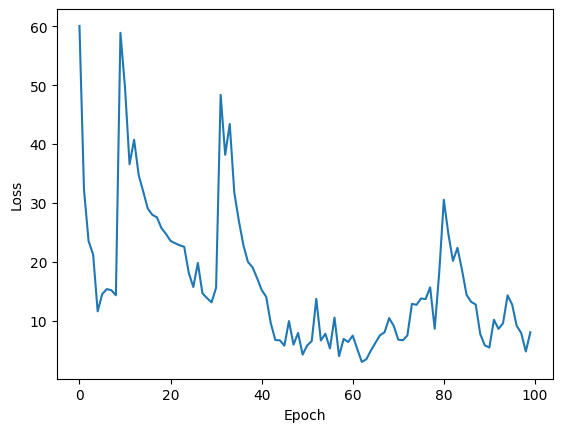

In [15]:
# Ploteamos el lost de entrenamiento
model.plot_loss()

In [16]:
# Evaluamos el modelo
preprocessor_test = Preprocessor('./test_data.txt', embedding_type='glove')
X_test = preprocessor_test.X
y_test = preprocessor_test.y

model.evaluate(X_test, y_test)

Cargando GloVe...
MSE: 0.9982002666220069


0.9982002666220069

In [17]:
# Predecimos el sentimiento de un texto
texto = "hoy es un buen día, pero me siento triste"
sentimiento = model.predict(texto)
print(sentimiento)

0.6321144104003906


In [19]:
texto1= 'La vida es dura y uno nunca aprenderá sobre la verdad de las cosas, todo es un misterio y el misterio una desgracia'
sentimiento = model.predict(texto1)
print(sentimiento)

0.1810878962278366


## Reestructuración de la clase Preprocesor

In [20]:
import pickle
import torch

class EmbeddingManager:
    def __init__(self, embedding_type='glove'):
        self.embedding_type = embedding_type

        if embedding_type == 'glove':
            print("Cargando GloVe...")
            # extraemos el archivo pickle
            self.embedding_model = pickle.load(open("glove_model.pkl", 'rb'))
            self.embedding_dim = 100
            print("Modelo GloVe cargado.")
        elif embedding_type == 'word2vec':
            print("Cargando Word2Vec...")
            self.embedding_model = pickle.load(open("word2vec_model.pkl", 'rb'))
            self.embedding_dim = 300
            print("Modelo Word2Vec cargado.")
        else:
            raise ValueError("Tipo de embedding no soportado. Usa 'glove' o 'word2vec'.")


    def get_embedding(self, words):
        embeddings = [torch.tensor(self.embedding_model[word]) for word in words if word in self.embedding_model]
        return embeddings if embeddings else [torch.zeros(self.embedding_dim)]
    
    def get_embedding_text(self,texto:str):
        ''' Método que obtiene los embeddings de un texto '''
        texto = re.findall(r'\w+', texto.lower())
        embeddings = [self.embedding_model[word] for word in texto if word in self.embedding_model]
        # Convertimos la lista de embeddings a un tensor
        if embeddings:
                # convertimos la lista de embeddings a un tensor
            embeddings = [torch.tensor(embedding) for embedding in embeddings]
        else:
            embeddings = np.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas

        return embeddings


In [21]:
import re
import pandas as pd

class Preprocessor:
    def __init__(self, path: str, embedding_manager: EmbeddingManager):
        self.path = path
        self.embedding_manager = embedding_manager
        self.text = self.read_path(self.path)
        self.data = self.create_data(self.text)
        self.df = pd.DataFrame(self.data)
        self.df['parrafos'] = self.df['parrafos'].apply(lambda x: re.findall(r'\w+', x.lower()))
        self.X, self.y = self.create_X_y()

    def read_path(self, path):
        with open(path, 'r', encoding='utf-8') as file:
            return file.read()

    def create_data(self, text):
        parrafos = re.findall(r'Parrafo_\d+:\n(.*?)\nsentimiento_\d+:\n', text, re.DOTALL)
        sentimientos = [float(s) for s in re.findall(r'sentimiento_\d+:\n(.*?)(?:\n|$)', text, re.DOTALL)]
        return {'parrafos': parrafos, 'sentimientos': sentimientos}

    def create_X_y(self):
        X = [self.embedding_manager.get_embedding(parrafo) for parrafo in self.df['parrafos']]
        y = [torch.tensor(sentimiento) for sentimiento in self.df['sentimientos']]
        return X, y
        

In [22]:
# Creamos una clase para analizar sentimientos
import matplotlib.pyplot as plt

class SentimentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, EmbeddingManager):
        super(SentimentRNN,self).__init__()
        # Atributos - preprocesador
        self.EmbeddingManager = EmbeddingManager

        # Atributos - modelo (tipo RNN_ANN)
        self.model= RNN_ANN(input_size,hidden_size,output_size)
        # Definimos la funcion de perdida
        self.loss = nn.MSELoss()
        # Definimos el optimizador (le pasamos los parametros del modelo)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self,X_train, y_train,epoch=10):
        ''' Metodo que entrena el modelo con un conjunto de datos de entrenamiento
        preprocesador como un conjunto de secuencias y sus targets
        '''
        # ALmacenamos la perdida total de cada epoca en una lista
        loss_list = []
        for e in range(epoch):
            # Almacenamos la perdida total
            total_loss = 0
            for secuencia,target in zip(X_train,y_train):
                #print(f'Secuencia: {secuencia}')
                #print(f'tamaño de la secuencia: {len(secuencia)}')
                # Inicializamos el gradiente
                self.optimizer.zero_grad()

                # Pasamos la secuencia a la red
                output = self.model(secuencia)

                # Imprimimos el output y el target
                #print(f'Output: {output}, Target: {target}')
                
                # Calculamos la perdida
                loss = self.loss(output,target)

                
                # Calculamos el gradiente
                loss.backward()

                # Actualizamos los pesos
                self.optimizer.step()

                # Acumulamos la perdida
                total_loss += loss.item()

            # Almacenamos la perdida total de la epoca
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        
        # Almacenamos los errores en un atributo
        self.loss_list = loss_list
    
    def plot_loss(self):
        ''' Metodo que grafica la perdida del modelo
        '''
        
        plt.plot(self.loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
    
    def evaluate(self,X_test,y_test):
        ''' Metodo que evalua el modelo con un conjunto de datos de test
        preprocesador como un conjunto de secuencias y sus targets
        '''
        correct = 0
        total = 0

        # Desactivamos el calculo de gradientes
        with torch.no_grad():
            # Almacenamos la perdida total
            total_loss = 0
            for secuencia,target in zip(X_test,y_test):
                output = self.model(secuencia)
                # Calculamos el loss
                loss = self.loss(output,target)
                # Acumulamos la perdida
                total_loss += loss.item()
            
            # Calculamos el error cuadratico medio
            mse = total_loss/len(X_test)
            print(f'MSE: {mse}')
        
        return mse
    
    def predict(self,texto):
        ''' Metodo que predice el sentimiento de un texto
        '''
        # Preprocesamos el texto
        secuencia = self.EmbeddingManager.get_embedding(texto)
        # Pasamos la secuencia por la red
        output = self.model(secuencia)
        # Retornamos el valor de salida
        return output.item()

In [37]:
# Creamos nuestro embedding manager
embedding_manager = EmbeddingManager(embedding_type='glove')

Cargando GloVe...
Modelo GloVe cargado.


In [41]:
# Creamos nuestro preprocesador
preprocessor_train = Preprocessor('./train_data.txt', embedding_manager)
preprocesor_test = Preprocessor('./test_data.txt', embedding_manager)

# Definimos los parametros
input_size = 100 # Dimension del embedding word2vec (300) , glove (100)
hidden_size = 300
output_size = 1

# Creamos el modelo
model = SentimentRNN(input_size, hidden_size, output_size, embedding_manager)

In [42]:
model.train(preprocessor_train.X, preprocessor_train.y, epoch=300)

Epoch 1 - Loss: 58.94402015632659
Epoch 2 - Loss: 33.81768679781089
Epoch 3 - Loss: 22.855105554911916
Epoch 4 - Loss: 15.765628426858257
Epoch 5 - Loss: 14.541127864576993
Epoch 6 - Loss: 24.57623060389013
Epoch 7 - Loss: 41.56059160914447
Epoch 8 - Loss: 41.725274483994326
Epoch 9 - Loss: 31.399277909338707
Epoch 10 - Loss: 39.35642598074628
Epoch 11 - Loss: 41.77434794558212
Epoch 12 - Loss: 39.99388355682186
Epoch 13 - Loss: 58.196925254696
Epoch 14 - Loss: 51.602978750146576
Epoch 15 - Loss: 46.064828356355065
Epoch 16 - Loss: 45.239287108898
Epoch 17 - Loss: 42.906784027290996
Epoch 18 - Loss: 31.49011891765622
Epoch 19 - Loss: 27.032737076457124
Epoch 20 - Loss: 22.542819293186767
Epoch 21 - Loss: 20.402821293290117
Epoch 22 - Loss: 46.982392302878
Epoch 23 - Loss: 39.85394489427563
Epoch 24 - Loss: 33.5449886954832
Epoch 25 - Loss: 31.543788347855298
Epoch 26 - Loss: 30.801136292806405
Epoch 27 - Loss: 25.805185410093834
Epoch 28 - Loss: 30.83431927049628
Epoch 29 - Loss: 28.04

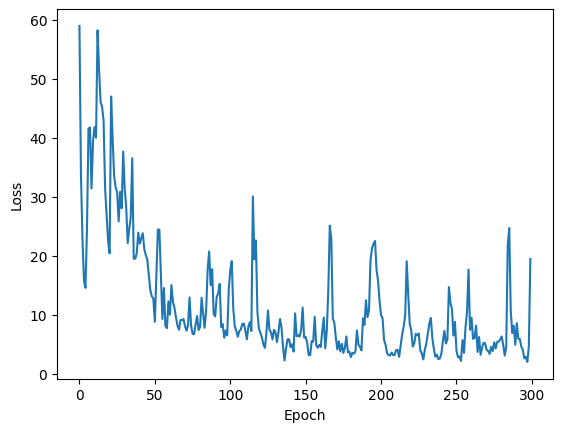

In [43]:
# Ploteamos el lost de entrenamiento
model.plot_loss()

In [46]:
# Probamos el modelo
model.evaluate(preprocesor_test.X, preprocesor_test.y)

MSE: 0.17996058687567712


0.17996058687567712

In [50]:
# Predecimos el sentimiento de un texto
texto = "hoy sera un día horrible y desagrable lo veo venir"
sentimiento = model.predict(texto)
print(sentimiento)

-0.5831872224807739
